In [5]:
import os
import sys
import numpy as np
import pandas as pd
import re
from prophet import Prophet
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.arima import AutoARIMA
import pandas as pd
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


In [6]:
df = pd.read_csv('air-traffic-prediction/parkingLot.csv')

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')
df = df[df['vehicle_no'].notna()]
df = df.dropna()
df = df[(df['timestamp'].dt.hour >= 5) & (df['timestamp'].dt.hour < 24)]
df = df.drop_duplicates()

In [8]:
entry_df = df[df['camera_id'] == 1]  # Entries (camera_id = 001)
exit_df = df[df['camera_id'] == 2]   # Exits (camera_id = 002)

# Rename columns for clarity
entry_df = entry_df.rename(columns={'timestamp': 'in_time'})
exit_df = exit_df.rename(columns={'timestamp': 'exit_time'})
merged_df = pd.merge(entry_df[['vehicle_no', 'in_time']], 
                    exit_df[['vehicle_no', 'exit_time']], 
                    on='vehicle_no', 
                    how='left')

merged_df['in_time'] = pd.to_datetime(merged_df['in_time'])
merged_df['timestamp_exit'] = pd.to_datetime(arg=merged_df['exit_time'])


# Ensure timestamps are on the same date by comparing just the date part
merged_df = merged_df[
    (merged_df['in_time'].dt.date == merged_df['exit_time'].dt.date) &
    (merged_df['in_time'] <= merged_df['exit_time'])
]
merged_df= merged_df.dropna()
merged_df['in_time'] = pd.to_datetime(merged_df['in_time'])
merged_df['date'] = merged_df['in_time'].dt.date


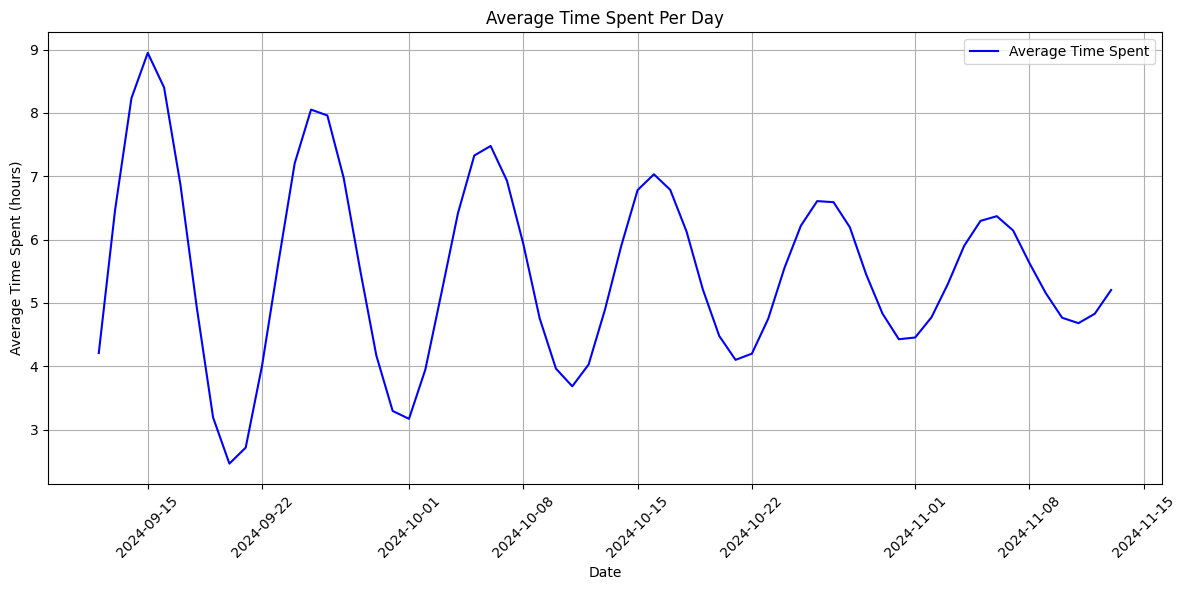

In [9]:
merged_df['time_spent'] = (merged_df['exit_time'] - merged_df['in_time']).dt.total_seconds() / 3600  # convert to hours
avg_time_spent = merged_df.groupby(by=merged_df['in_time'].dt.date)['time_spent'].mean()
y_time = pd.DataFrame(data=avg_time_spent, index=pd.to_datetime(avg_time_spent.index))
y_train_time, y_test_time = temporal_train_test_split(y_time, test_size=7)
plt.figure(figsize=(12, 6))
plt.plot(y_time.index, y_time['time_spent'], label="Average Time Spent", color='blue')
# Formatting the plot
plt.title('Average Time Spent Per Day')
plt.xlabel('Date')
plt.ylabel('Average Time Spent (hours)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Calculate Mean Absolute Scaled Error (MASE).
    
    :param y_true: Array-like, true values
    :param y_pred: Array-like, predicted values
    :return: float, MASE value
    """
    # Calculate the mean absolute error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate the naive forecast errors
    naive_forecast = np.roll(y_true.astype(float), 1)  # Ensure it's float
    naive_forecast[0] = np.nan  # First value has no naive forecast
    naive_error = np.abs(y_true - naive_forecast)

    # Calculate the mean absolute error of the naive forecast (MAE)
    mae_naive = np.nanmean(naive_error)  # Ignore NaN values in the calculation
    
    # Calculate MASE
    mase = mae / mae_naive if mae_naive != 0 else np.nan  # Handle division by zero
    
    return mase


In [11]:
#  AutoARIMA Model Training and Forecasting
model_time = AutoARIMA(sp=7, suppress_warnings=True, seasonal=True)
model_time.fit(y=y_train_time)

# Forecasting
y_pred_time = model_time.predict(fh=np.arange(1, 8))

# Calculate MASE and MAPE for AutoARIMA
mase_arima = mean_absolute_scaled_error(y_true=y_test_time, y_pred=y_pred_time)
mape_arima = mean_absolute_percentage_error(y_test_time, y_pred_time)

# Print Results
print("AutoARIMA MASE:", mase_arima)
print("AutoARIMA MAPE:", mape_arima * 100)

AutoARIMA MASE: 0.24172740554367744
AutoARIMA MAPE: 1.5455385810359743


In [12]:
exp_smoothing_model = ExponentialSmoothing(y_train_time, trend='add', seasonal='add', seasonal_periods=7).fit()

# Forecasting
forecast_exp_smoothing = exp_smoothing_model.forecast(steps=7)

# Calculate MASE and MAPE for Exponential Smoothing
mase_exp_smoothing = mean_absolute_scaled_error(y_true=y_test_time, y_pred=forecast_exp_smoothing)
mape_exp_smoothing = mean_absolute_percentage_error(y_test_time, forecast_exp_smoothing)

# Print Results
print("Exponential Smoothing MASE:", mase_exp_smoothing)
print("Exponential Smoothing MAPE:", mape_exp_smoothing * 100)

Exponential Smoothing MASE: 6.084128247867861
Exponential Smoothing MAPE: 40.50103373857137


c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


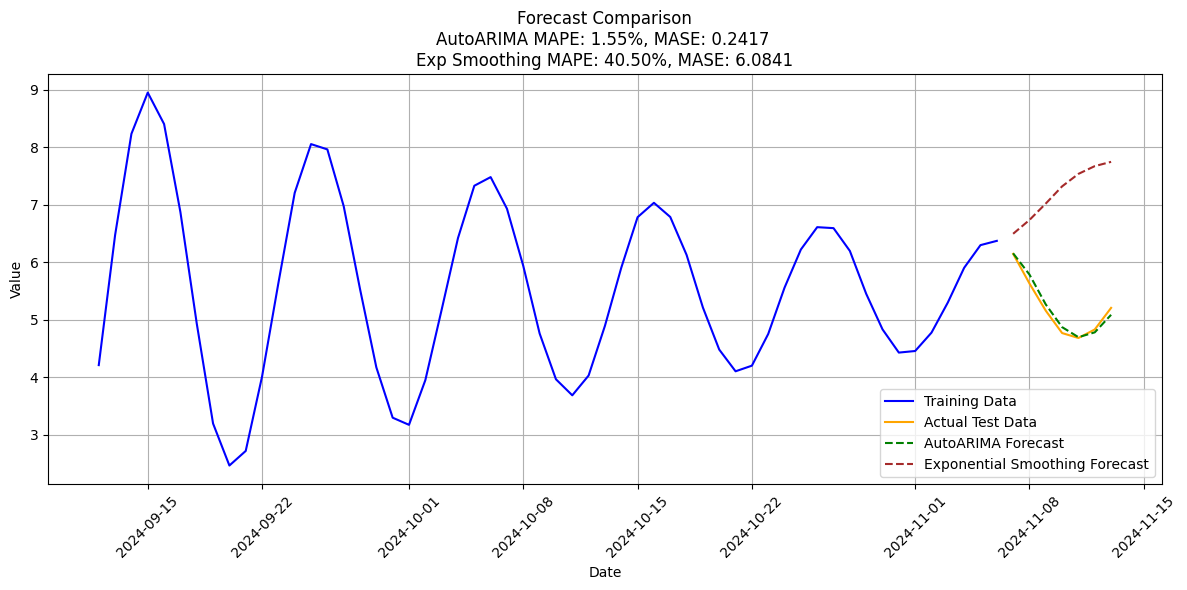

In [13]:
plt.figure(figsize=(12, 6))
# Plot training data
plt.plot(y_train_time.index, y_train_time, label="Training Data", color='blue')
# Plot test data
plt.plot(y_test_time.index, y_test_time, label="Actual Test Data", color='orange')

# Plot forecasts from each model
plt.plot(y_test_time.index, y_pred_time, label="AutoARIMA Forecast", linestyle='--', color='green')

plt.plot(y_test_time.index, forecast_exp_smoothing, label="Exponential Smoothing Forecast", linestyle='--', color='brown')

# Adding titles and labels
plt.title(f'Forecast Comparison\n'
        f'AutoARIMA MAPE: {mape_arima * 100:.2f}%, MASE: {mase_arima:.4f} \n'
        f'Exp Smoothing MAPE: {mape_exp_smoothing * 100:.2f}%, MASE: {mase_exp_smoothing:.4f}')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Here we clearly see that Auto arima is way better than Exponential SMoothening